# 서울 부동산 시장 분석 및 투자 전략 수립

## 과제 2: 아파트 규모별 가격 트렌드 및 생애주기 투자 전략

전용면적별(소형, 중형, 대형) 아파트의 가격 변동 추이를 분석, 생애주기와 데이터 분석에 따른 최적 투자 전략과 거주 전략을 제시

- 전용면적 기준으로 분류 후 규모별 가격 변동 추이 분석, 시각화
- 생애주기
  - 20~30: 신혼 / 첫 주택 구입 시기 
  - 40~50: 자산 증식 시기
  - 60~  : 다운사이징 / 현금화 단계

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_sales = pd.read_csv('./data/sales_clean.csv')
df_sales['계약일'] = pd.to_datetime(df_sales['계약일'], format='%Y%m%d')

df_sales_copy = df_sales.copy()
# display(df_sales_copy.head())

In [73]:
# 전용면적 기준 분류 및 필요 컬럼 추출
def area(df):
    if df['전용면적'] >= 85:
        return '대형'
    elif df['전용면적'] >= 60:
        return '중형'
    else:
        return '소형'

df_area_analysis = pd.DataFrame({
    '전용면적': df_sales_copy['전용면적'],
    '계약월': pd.to_datetime(df_sales_copy['계약월'], format='%Y-%m-%d'),
    '건축년도': df_sales_copy['건축년도'],
    '거래금액': df_sales_copy['거래금액'],
    '평단가': df_sales_copy['평단가'],
    '면적구분': df_sales_copy.apply(area, axis=1),
    '신축구분': df_sales_copy['건축년도'].apply(lambda x: '신축' if 2025 - x <= 10 else '중고')
})

# display(df_area_analysis.head())

In [80]:
# 월간/연간 통계 분석
from da_utils.calc_monthly_annual import calc_monthly_annual
monthly_stats, annual_stats = calc_monthly_annual(df_area_analysis, '면적구분')
# display(monthly_stats, annual_stats)

In [82]:
# 건축년도 기반 추가분석
## 면적별 전체 분석
year_by_area = df_area_analysis.groupby('면적구분').agg({
    '건축년도': ['mean', 'count'],
    '거래금액': ['mean', 'sum']
    }).reset_index().round(2)
year_by_area.columns = ['면적구분', '평균건축년도', '거래량', '평균거래금액', '총거래금액']

## (면적-신축/중고)에 따른 추가분석
new_old_ratio = df_area_analysis.groupby(['면적구분', '신축구분']).size().reset_index(name='거래량')
new_old_ratio['비율(%)'] = new_old_ratio.groupby('면적구분')['거래량'].apply(lambda x: x * 100 / x.sum()).values.round(2)

# 보기 편하게 정렬
area_order = ['소형', '중형', '대형']
year_by_area['면적구분'] = pd.Categorical(year_by_area['면적구분'], categories=area_order, ordered=True)
year_by_area = year_by_area.sort_values(['면적구분'])

new_old_ratio['면적구분'] = pd.Categorical(new_old_ratio['면적구분'], categories=area_order, ordered=True)
new_old_ratio = new_old_ratio.sort_values(['면적구분'])

# display('year_by_area', year_by_area, 'new_old_ratio', new_old_ratio)

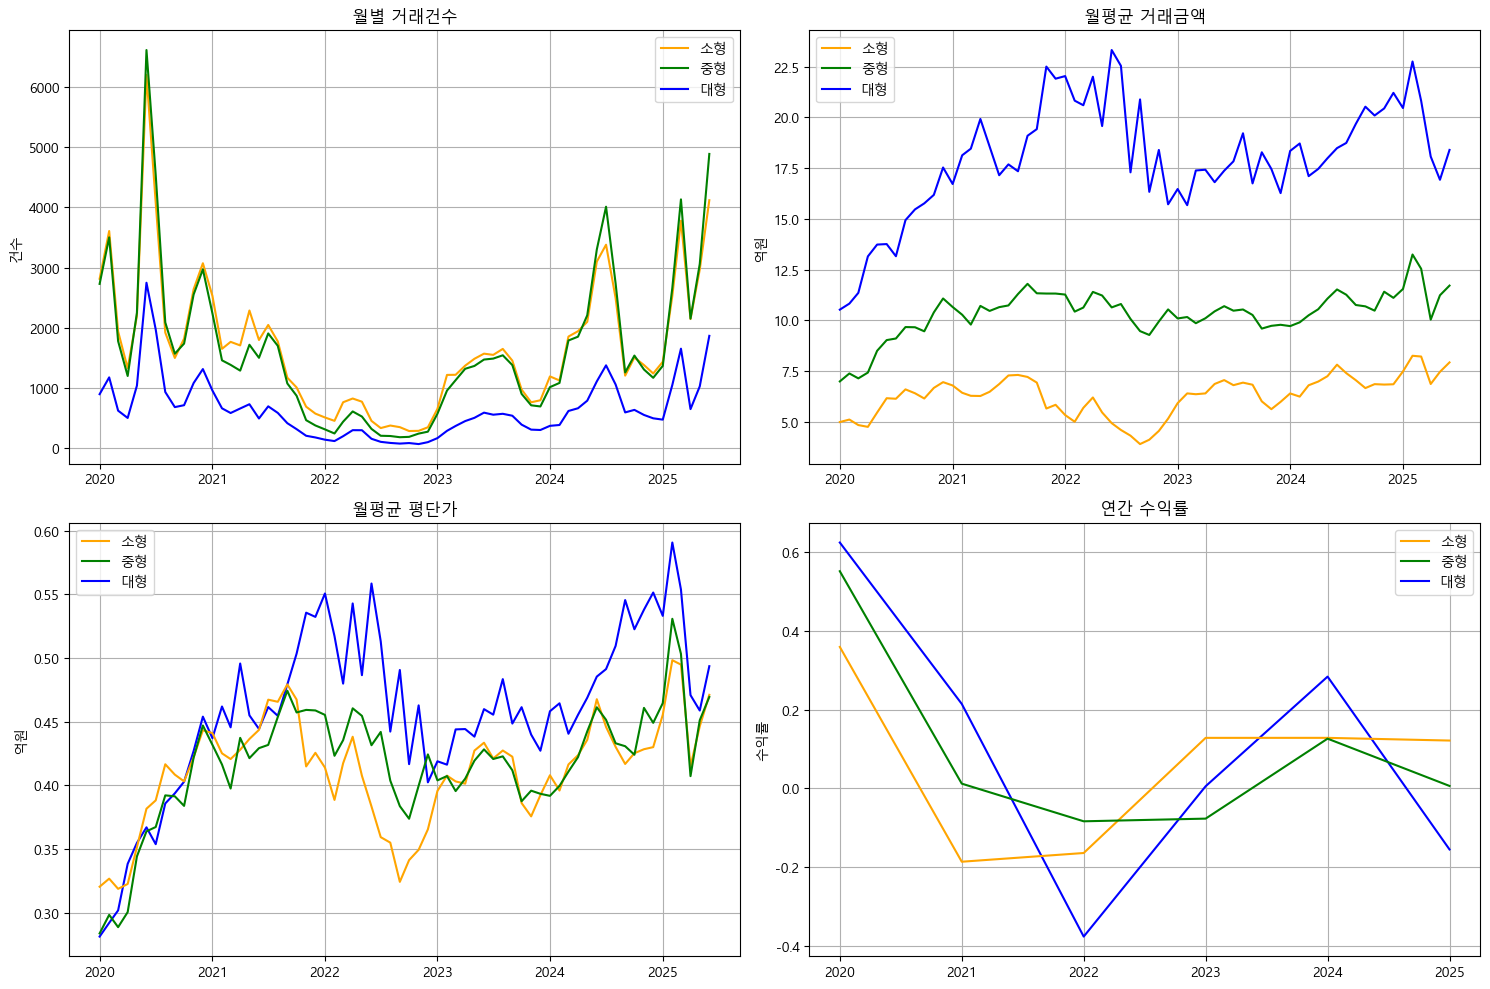

In [77]:
import matplotlib.pyplot as plt

# 면적구분 목록
area_types = monthly_stats['면적구분'].unique()
colors = ['blue', 'orange', 'green']  # 면적구분별 색상 지정

# Figure와 서브플롯 생성 (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# 1. 월별 거래건수
for i, area in enumerate(area_types):
    data = monthly_stats[monthly_stats['면적구분'] == area]
    axes[0].plot(data['계약월'], data['월별거래건수'], label=area, color=colors[i])
axes[0].set_title('월별 거래건수')
axes[0].set_ylabel('건수')
axes[0].legend()
axes[0].grid(True)

# 2. 월평균 거래금액 (억 단위)
for i, area in enumerate(area_types):
    data = monthly_stats[monthly_stats['면적구분'] == area]
    axes[1].plot(data['계약월'], data['월평균거래금액']/1e8, label=area, color=colors[i])
axes[1].set_title('월평균 거래금액')
axes[1].set_ylabel('억원')
axes[1].legend()
axes[1].grid(True)

# 3. 월평균 평단가 (억 단위)
for i, area in enumerate(area_types):
    data = monthly_stats[monthly_stats['면적구분'] == area]
    axes[2].plot(data['계약월'], data['월평균평단가']/1e8, label=area, color=colors[i])
axes[2].set_title('월평균 평단가')
axes[2].set_ylabel('억원')
axes[2].legend()
axes[2].grid(True)

# 4. 월별 수익률
for i, area in enumerate(area_types):
    data = annual_stats[annual_stats['면적구분'] == area]
    axes[3].plot(data['연도'], data['연간수익률'], label=area, color=colors[i])
axes[3].set_title('연간 수익률')
axes[3].set_ylabel('수익률')
axes[3].legend()
axes[3].grid(True)

# 범례 순서 조정
for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    ordered_handles = [handles[labels.index(o)] for o in area_order if o in labels]
    ordered_labels = [o for o in area_order if o in labels]
    ax.legend(ordered_handles, ordered_labels)


plt.tight_layout()
plt.show()

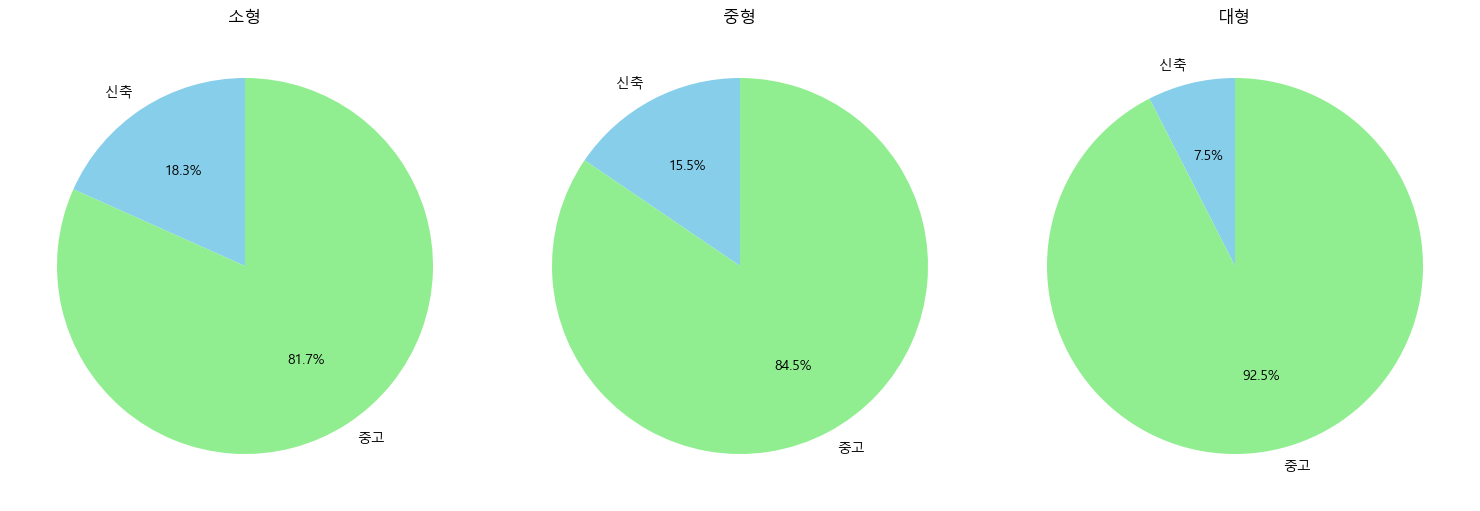

In [ ]:
import matplotlib.pyplot as plt

# 면적별 파이 차트 그리기
area_categories = new_old_ratio['면적구분'].unique()
fig, axes = plt.subplots(1, len(area_categories), figsize=(5 * len(area_categories), 5))

for ax, area in zip(axes, area_categories):
    subset = new_old_ratio[new_old_ratio['면적구분'] == area]
    ax.pie(subset['비율(%)'], labels=subset['신축구분'], autopct='%1.1f%%', startangle=90, colors=['skyblue','lightgreen'])
    ax.set_title(f'{area}')

plt.tight_layout()
plt.show()

## 생애주기 투자 전략 - 가중치 부여 후 점수로 비교할 것

### 선정기준
- 거래량: 진입장벽, 유동성
- 평단가/평균거래금액: 초기 투자금, 자산 규모
- 월/연간 수익률, 변동성: 위험 대비 수익
- 신축구분: 선호도, 신축/중고 별 거래량 차이

### 생애주기
1. 20 ~ 30: 신혼/첫 주택 구입 시기 -> 수입이 적고, 초기 자산 마련 목적
- 거래량: 진입 장벽 낮음, 유동성 조금 낮아도 상관 없음(0)
- 평단가/월평균 거래금액: 초기 투자금 및 자산 규모가 적다.(낮을수록 좋음. -1) 
- 월별/연별 수익률과 변동성: 위험 대비 수익 판단(변동성은 -1, 수익률은 +1)
- 신축/중고: 초기 안정성 및 자산 가치 유지 목적(신축 +1)

1. 40 ~ 60: 자산 증식 시기 -> 자금여력 증가
- 거래량: 거래량이 높을수록 자산 증식 가능성이 높아 선호(+1)
- 평단가/월평균 거래금액: 자산 증식 시기이기 때문에, 투자 여력이 높다(+1)
- 월별/연별 수익률과 변동성: 수익률 극대화 및 리스크 관리(수익률 +1, 변동성 0)
- 신축/중고: 투자 포트폴리오 다양화 및 리스크 분산(0)

1. 60 ~   : 다운사이징, 현금화 시기 -> 노후자금 확보 및 유지비 절감
- 거래량: 안정적 현금화 가능해야 함(+1)
- 평단가/월평균 거래금액: 투자금 회수 용이(0)
- 월별/연별 수익률과 변동성: 가격 변동성 낮은 자산 선호(수익률 0, 변동성 -1)
- 신축/중고: 가격 안정성이 높은 중고 중심(중고 +1)

### 거주 <-> 투자
- 거래량: 거주전략에선 조금 낮아도 상관없음(0) / 투자전략에서는 명확하게 높아야 함(+1)
- 평단가/거래금액: 거주전략에서는 낮을수록 좋음(-1) / 투자전략에서는 수익률이 더 중요함(0)
- 월/연간 수익률, 변동성: 거주전략에서는 낮아도 크게 문제 없음(0) / 투자전략에서는 수익률(+1)이 높고, 변동성이 낮을수록 좋다(-1)
- 신축구분: 거주전략에서는 신축에 선호도가 높음(신축+1) / 투자전략에서는 중고가 거래량이 더 높아 좋다(중고비율에 +1)

In [86]:
# 생애주기별 가중치
lifecycle_w = {
    "청년": {"거래량":0, "거래금액":-1, "수익률":0, "변동성":0, "신축":1},
    "중년": {"거래량":1, "거래금액":1, "수익률":0, "변동성":0, "신축":0},
    "노년": {"거래량":1, "거래금액":0, "수익률":0, "변동성":-1, "신축":0}
}

# 전략별 가중치
strategy_w = {
    "거주": {"거래량":0, "거래금액":0, "수익률":0, "변동성":0, "신축":1},
    "투자": {"거래량":1, "거래금액":0, "수익률":1, "변동성":-1, "신축":-1}
}

# 합 방식으로 최종 가중치 생성
final_w = {}
for lc in lifecycle_w:
    for st in strategy_w:
        final_w[(lc, st)] = {k: lifecycle_w[lc][k] + strategy_w[st][k] for k in lifecycle_w[lc]}

# 결과 확인
for key, val in final_w.items():
    print(key, val)


('청년', '거주') {'거래량': 0, '거래금액': -1, '수익률': 0, '변동성': 0, '신축': 2}
('청년', '투자') {'거래량': 1, '거래금액': -1, '수익률': 1, '변동성': -1, '신축': 0}
('중년', '거주') {'거래량': 1, '거래금액': 1, '수익률': 0, '변동성': 0, '신축': 1}
('중년', '투자') {'거래량': 2, '거래금액': 1, '수익률': 1, '변동성': -1, '신축': -1}
('노년', '거주') {'거래량': 1, '거래금액': 0, '수익률': 0, '변동성': -1, '신축': 1}
('노년', '투자') {'거래량': 2, '거래금액': 0, '수익률': 1, '변동성': -2, '신축': -1}


In [96]:
# 지표 표준화

# 거래량, 거래금액
year_stats = year_by_area.set_index("면적구분")[["거래량", "평균거래금액"]]

# 수익률, 변동성
annual_stats_idx = annual_stats.groupby("면적구분")[["연간수익률", "변동성"]].mean()

# 신축비율
new_ratio = new_old_ratio.pivot(index="면적구분", columns="신축구분", values="비율(%)")
# 신축비율만 사용
new_ratio = new_ratio.get("신축", pd.Series(0, index=new_ratio.index))

# 데이터 통합
df_std = pd.concat([year_stats, annual_stats_idx, new_ratio.rename("신축")], axis=1)
df_std = df_std.rename(columns={"평균거래금액": "거래금액", "연간수익률": "수익률", })

# z-score 표준화
df_std = (df_std - df_std.mean()) / df_std.std()

# 변동성은 낮을수록 선호 → 부호 반전
df_std["변동성"] = -df_std["변동성"]

display(df_std)

,거래량,거래금액,수익률,변동성,신축
면적구분,,,,,
소형,0.624419,-0.886593,-1.107575,-0.368975,0.810685
중형,0.528966,-0.197378,0.271018,1.132060,0.306762
대형,-1.153385,1.083972,0.836557,-0.763085,-1.117447


In [98]:
# 면적구분별 점수 계산
scores = {}

for (lifecycle, strategy), w in final_w.items():
    score_dict = {}
    for area in df_std.index:
        # 각 지표별 표준화 값 * 가중치 합
        score = sum(df_std.loc[area, col] * w[col] for col in w)
        score_dict[area] = score
    scores[(lifecycle, strategy)] = score_dict

# 데이터프레임으로 변환
score_df = pd.DataFrame(scores).T  # 행: (생애주기, 전략), 열: 면적구분
score_df["선택"] = score_df.idxmax(axis=1)  # 최대 점수 면적 선택

# 결과 확인
display(score_df)


소형        중형        대형  선택
청년 거주  2.507963  0.810902 -3.318865  소형
   투자  0.772412 -0.134697 -0.637714  소형
중년 거주  0.548511  0.638349 -1.186860  중형
   투자 -1.187041 -0.307250  1.494291  대형
노년 거주  1.804078 -0.296332 -1.507746  소형
   투자  0.068527 -1.241931  1.173404  대형